# RNN / BiLSTM 

The basic idea of a Neural Network is having many perceptrons connected to each other in a network, immitating the way neurons are connected in the brain through their axons.

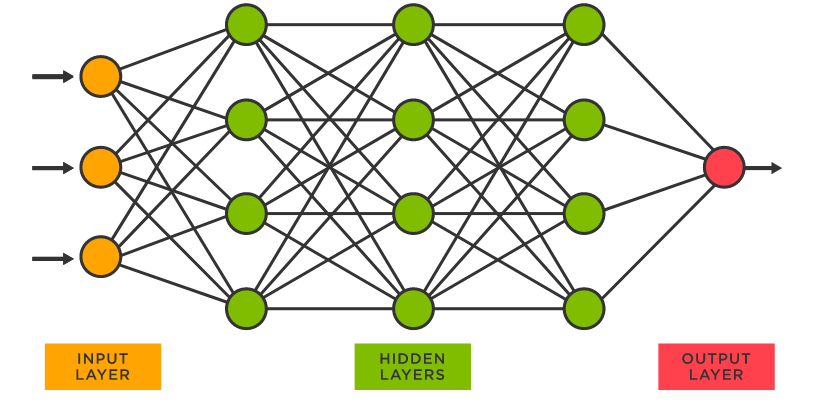


Like any other supervised classifier (k-NN, Logistic-Regression, Naive Bayes, Support Vector Machine), also neural networks expects some input vector (a list of numbers) in a fixed size, a fixed length, and they output a vector in a fixed length.

But neural Networks are very flexible. **You** decide how many neurons it will be made of: How many input neurons, hidden middle neurons and layers, and output neurons it will have. The number of input and output neurons that you set, determins the size of those input and output vectors (the input can only accept one single number, and every neuron can output only one single number).

So, if this is the case - how can we process sentences? After all, they come in different sizes:

- "Yes".
- "Five famous artworks were displayed upside down."
- "On offering to help the blind man, the man who then stole his car, had not, at that precise moment, had any evil intention, quite the contrary, what he did was nothing more than obey those feelings of generosity and altruism which, as everyone knows, are the two best traits of human nature and to be found in much more hardened criminals than this one, a simple car-thief without any hope of advancing in his profession, exploited by the real owners of this enterprise, for it is they who take advantage of the needs of the poor."

How can we tackle that?

As we mentioned before, NLP is all about **compromises**. One way to solve it is to simply *limit the number of words a sentence can have*. On one hand we simplify our neural network, but we are aware that we won't be able to handle just every input...

#### Recurrent Neural Network (RNN)

But here's another idea (which is not new and rooted in the 80's and early 90's - see Elman, Jordan, Mozer, Hopfield, Parallel Distributed 
Processing group).

If we define the NN to handle every time only *2* inputs: 
1. the sentence's word that we would like to process, and - 
2. whatever came before that (as one, fixed-sized, input).


The following diagram illustrates the idea:


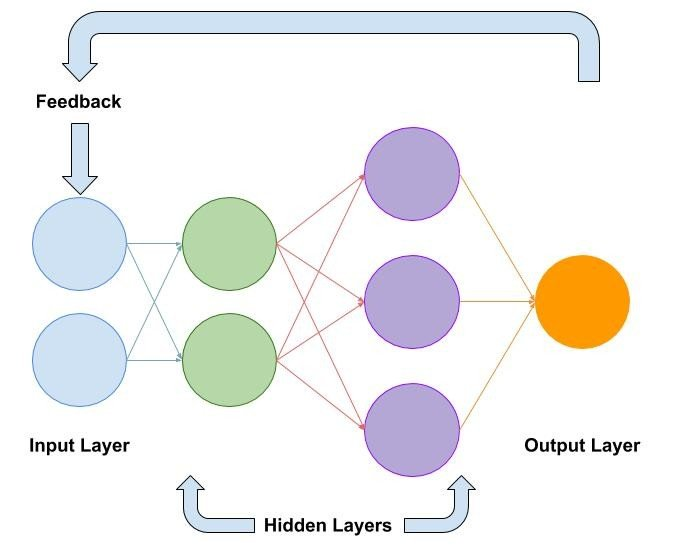

This idea of a recurrent input had developed a lot in the past few decades. The first attempts were not so successful and hard to train due to the nature of the network and the training process: comparing the output to the real, desired, output, calculating this comparison distance, hence giving it some error-score, and updataing the network weights according to this error - but only with a small fraction of that error (due to multiplying it by some learning-rate value). The result was that this error often became 0 quite quicly, and the network simply didn't learn - the weights didn't change.

As a result, modern versions of RNN appeared, such as Long Short-Term Memory (LSTM) which the error could be used to teach the network.

RNN/LSTMs became the de-facto tool for every NLP practitioner in 2017 (before transformers such as the BERT family), and even today it is widely used for many cases: from OCR of heavly text-documents, limited-resources languages and long documents, cases where the BERT-based models don't perform well. Hence it is still important to get acquaintance with this tool.

LSTM is VERY flexible: it can be used to output a single output (e.g., for sentence or document classification) or a sequence of outpus (for document summarization or for translation). 

## Learning Goals
In this exercise we will look into LSTM and its building blocks.

By the end of this exercise, you should:

* know how to put together the building blocks used in RNNs and its variants (LSTM) in pyTorch with an example.
* have a good undertanding on how sequences -- any data that has some temporal semantics (e.g., time series, natural language, images etc.) -- fit into and benefit from a recurrent architecture
* be familiar with preprocessing text and dynamic embeddings
* be familiar with gradient issues on RNNs processing longer sentence lengths
* understand different kinds of LSTM architectures, classifiers, sequence to sequence models and their far-reaching applications



## 1. Intent Classification: FeedForward, CNN, RNN, LSTM

In this task, we are going to do intent classification on an intent dataset. We are going to build a feedforward net, a convolutional neural net, a recurrent net and combine one or more of them to understand performance of each of them. A sentence can be thought of as a sequence of words that collectively represent meaning. Individual words impact the meaning. Thus, the context matters; words that occur earlier in the sentence influence the sentence's structure and meaning in the latter part of the sentence (e.g., Jose asked Anqi if she were going to the library today). Likewise, words that occur later in a sentence can affect the meaning of earlier words (e.g., Apple is an interesting company). As we have seen in lecture, if we wish to make use of a full sentence's context in both directions, then we should use a bi-directional RNN (e.g., Bi-LSTM). For the purpose of this tutorial, we are going to restrict ourselves to only uni-directional RNNs.

In [36]:
%%capture
!pip install bpemb datasets

In [37]:
from pathlib import Path
from typing import Tuple

import pandas as pd
import torch
import torch.nn.functional as F
import torchtext
from bpemb import BPEmb
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from torch import Tensor, nn
from tqdm.notebook import tqdm

In [38]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = 'cpu'

print(f"using the device {device}")

using the device cpu


Computers have no built-in knowledge of words or their meanings and cannot understand them in any rich way that humans do -- hence, the purpose of Natural Language Processing (NLP). As with any data science, computer science, machine learning task, the first crucial step is to clean (pre-process) your data so that you can soundly make use of it. Within NLP, this first step is called Tokenization and it concerns how to represent each token (a.k.a. word) of your corpus (i.e., dataset).



### Tokenization

A token refers to a single, atomic unit of meaning (i.e., a word). How should our computers represent each word? We could read in our corpus word by word and store each word as a String (data structure). However, Strings tend to use more computer memory than Integers and can become cumbersome. As long as we preserve the uniqueness of the tokens and are consistent, we are better off converting each distinct word to a distinct number (Integer). This is standard practice within NLP / computer science / data science, etc. As a simple example of tokenization, we can see a small example.

If the five sentences below were our entire corpus, our conversion would look as follows:

* i have books - [1, 4, 7]
* interesting books are useful [10,2,9,8]
* i have computers [1,4,6]
* computers are interesting and useful [6,9,11,10,8]
* books and computers are both valuable. [2,10,2,9,13,12]
* Bye Bye [7,7]

Create tokens for vocabulary based on frequency of occurrence. Hence, we assign the following tokens

`I-1, books-2, computers-3, have-4, are-5, computers-6,bye-7, useful-8, are-9, and-10,interesting-11, valuable-12, both-13`

NOTE: Often times, depending on your NLP task, it is useful to also perform other pre-processing, cleaning steps, such as:

* treating each punctuation mark as a token (e.g., , . ! ? are each separate tokens)
* lower-casing all words (so that a given word isn't treated differently just because it starts a sentence or not)
* separating each sentence with a unique symbol (e.g., and )
* removing words that are incredibly common (e.g., function words, (in)definite articles). These are referred to as 'stopwords'). For **language modelling**, we DO NOT remove stopwords. A sentence's meaning needs to include all of the original words.

### Load Data

The package `datasets` from [Huggingface](https://huggingface.co/datasets) is an excellent and a commonly used way to access and use many datasets from the huggingface hub.

In this exercise, we will load an **intent dataset** from their hub. Intents are commands we give to digital assistant, such as Siri, Alexa, Google assistant, etc.  

#### Have you ever wondered how they work?
Virtual assistants operates in three general steps:
1. When we say a command, it is first converted from speech to text. 
2. A model classifies this text into categories (called intents) to determine what the user asks. 
3. After the intent is predicted, the model extracts the relevant data, according on the intent template, and fills in the needed information.

Here we will assume the speech is converted to text, and we will focus on the second step of classifying the intent.

In [39]:
dataset = load_dataset("snips_built_in_intents", split="train")

dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['ComparePlaces', 'RequestRide', 'GetWeather', 'SearchPlace', 'GetPlaceDetails', 'ShareCurrentLocation', 'GetTrafficInformation', 'BookRestaurant', 'GetDirections', 'ShareETA'], id=None)}

We can convert the dataset object into different formats. For example, pandas: 

In [40]:
dataset.to_pandas() 

,text,label
0,Share my location with Hillary's sister,5
1,Send my current location to my father,5
2,Share my current location with Jim,5
3,Send my location to my husband,5
4,Send my location,5
...,...,...
323,Will it rain tomorrow near my all day event?,2
324,I need the weather at Jo's place around 8 pm,2
325,What will the weather be like when I get out o...,2
326,Show me the forecast for my upcoming weekend,2


Or into a dictionary:

In [41]:
dataset_dict = dataset.to_dict()
X_train = dataset_dict['text']
y_train = dataset_dict['label']

assert len(X_train) > 0
assert len(X_train) == len(y_train)

print(f"number of intents: {len(X_train)}")
print('Length of first and fifth intent before padding', len(X_train[0]) ,len(X_train[4]))
print('First intent: ', X_train[0])
print('First label: ', y_train[0])


number of intents: 328
Length of first and fifth intent before padding 39 16
First intent:  Share my location with Hillary's sister
First label:  5


## MODEL 1A : FEED-FORWARD NETWORKS WITHOUT EMBEDDINGS

First we must tokenize our dataset, break the sentences into words and assign each word a unique number. 

We have multiple options To process our tokenized sentences through a neural network. For example:
1. We can use a one-hot vector or a count-vector as long as the size of our vocabulary to represent each sentence, and match accordingly the network input layer to be the same size of our vocabulary. The input is then a bag-of-words.
2. Alternatively, we can set the input layer to a fixed size, say 256. Every sentence is then broken down into a list of word-indeces, and either padded with zeros if its length is less than 256, or broken down to multiple inputs if it is longer han 255.   

We will do it here in the second way, with a fixed input size.

In [50]:
# First we need a tokenizer. We use the pytorch one:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
# and we use the .map method of the dataset, to apply the tokenizer to every
# sample in our dataset:
tokenize_data = lambda example, tokenizer: {'tokens': tokenizer(example['text'])}  
tokenized_dataset = dataset.map(tokenize_data, remove_columns=['text'], fn_kwargs={'tokenizer': tokenizer})

# Now our dataset is tokenized:
print(tokenized_dataset[80:88]['tokens'])

[['give', 'me', 'steve', "'", 's', 'address', 'in', 'manhattan'], ['does', 'cafe', 'gitane', 'have', 'wifi', '?'], ['what', "'", 's', 'today', "'", 's', 'menu', 'at', 'the', 'water', 'club', '?'], ['when', 'is', 'it', 'the', 'quietest', 'at', 'good', 'luck', 'bar', '?'], ['is', 'there', 'valet', 'parking', 'at', 'kang', 'ho', 'dong', 'baekjeong', '?'], ['show', 'me', 'the', 'cheapest', 'cocktail', 'bar', 'near', 'the', 'hotel', 'my', 'sister', 'stays', 'in'], ['find', 'me', 'a', 'restaurant', 'similar', 'to', 'the', 'one', 'i', 'went', 'to', 'yesterday', 'evening'], ['show', 'me', 'the', 'closest', 'restaurants', 'with', 'all', 'you', 'can', 'eat', 'buffets']]


In [51]:
# Next we need to convert the words into numeric representation.
# We first build a vocabulary with all the different words, each has an ID:
vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_dataset['tokens'], 
                                                  min_freq=3) 

# And we add two more tokens for unknown words and 'end-of-sentence':
vocab.insert_token('<unk>', 0)
vocab.insert_token('<eos>', 1)
vocab.set_default_index(vocab['<unk>'])

print(f"The vocabulary size is: {len(vocab)}")                         
print(vocab.get_itos()[:20])

The vocabulary size is: 210
['<unk>', '<eos>', 'the', 'to', '?', 'a', 'my', 'at', "'", 'for', 's', 'i', 'me', 'is', 'table', 'book', 'what', 'in', 'with', 'restaurant']


#### Processing in batches

In Neural Networks, we can't feed all the data at once - we don't have enough memory for it. On the other side, we don't want to process one sample after another... So instead, we process them in smaller groups called **batches**.

The batch size is actually a hyperparameter for training the network. It depends on your GPU's memory size and has also an affect the model performance.

In [45]:
# To process the data in batches, one option is to just stack all the sentences 
# together, as shown here:
# https://towardsdatascience.com/language-modeling-with-lstms-in-pytorch-381a26badcbf

def get_data(dataset, vocab, batch_size):
    data = []
    for example in dataset:
        if example['tokens']:
            tokens = example['tokens'].append('<eos>')             
            tokens = [vocab[token] for token in example['tokens']] 
            data.extend(tokens)
    data = torch.LongTensor(data)
    num_batches = data.shape[0] // batch_size
    data = data[:num_batches * batch_size]
    data = data.view(batch_size, num_batches)
    return data

# Notice that train_data[:, i] is the batch of next tokens for train_data[:, i - 1] 

In [52]:
data = get_data(tokenized_dataset, vocab, 4)
print(f"the data shape is: {data.shape}")
data

the data shape is: torch.Size([4, 928])


tensor([[ 29,   6,  37,  ...,   0,   0,   4],
        [  1,  78,  13,  ...,   1,  95,   5],
        [ 51,   9,  80,  ...,   3, 207,   1],
        [172, 102,   3,  ...,  60,   4,   1]])

However, through this method, we are losing the connection to our target, our y. We could have an input - that has no target to classify...
This method works well for training a **language model** (where we always need to detect the next word in the serie), but not for classifying sentences.

So, alternatively, instead of packing all the sentences together, we can *pad* them to reach a fixed length. This way, we have fixed size for every sentence, AND we can easily match the X to its y, since we have the same lengthes for both the *X_train* and *y_train*.

Let's see how it is done:

In [ ]:
from torch.nn.utils.rnn import pad_sequence

dataset.map()

def get_data(dataset, vocab, batch_size):
    data = []
    for example in dataset:
        if example['tokens']:
            tokens = example['tokens'].append('<eos>')             
            tokens = [vocab[token] for token in example['tokens']] 
            data.extend(tokens)
    data = torch.LongTensor(data)
    num_batches = data.shape[0] // batch_size
    data = data[:num_batches * batch_size]
    data = data.view(batch_size, num_batches)
    return data

# Notice that train_data[:, i] is the batch of next tokens for train_data[:, i - 1] 


Now let us build a single-layer feed-forward net in [pyTorch](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) with a single hidden layer of 256 nodes. Each input would be a 625-dim vector of tokens since our vocabulary size is 625.

**EXERCISE**: Calculate the number of parameters involved in this network and implement a feedforward net to do classification **without looking at cells below**.


In [59]:
#@title Click `Show code` to see the answer. { display-mode: "form" }
class FeedForwardNeuralNetworkModel(nn.Module):
  """A simple feed forward neural network to process our intents
  """

    def __init__(self):
        super(FeedForwardNeuralNetworkModel, self).__init__()

        self.input = nn.

        # The encoder will be used as the input layer of the network.
        # It will convert our words input, into vectors, by converting them into
        # word-parts (a sequence of letters), and transforming them into
        # a vector representation as its output (which will be the input of our
        # LSTM network)
        self.encoder = nn.Embedding.from_pretrained(tensor(bpemb_en.vectors))

        # LSTM (Long Short-Term Memory) is a version of RNN that 'remembers'
        # the previous steps and therefore converges better on longer sequences.
        # So instead of using RNN, like so:
        # `self.rnn = nn.RNN(ninp, nhid, nlayers, nonlinearity='relu', dropout=dropout)`
        # We should use LSTM:
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)

        # This is our output layer. 
        # Notice that the first parameter, its input size must match the LSTM 
        # output size, and its second parameter, its output size, is the size of
        # the classes we want the network to classify. 
        self.decoder = nn.Linear(nhid, noutp)

        # Optionally tie weights as in:
        # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
        # https://arxiv.org/abs/1608.05859
        # and
        # "Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling" (Inan et al. 2016)
        # https://arxiv.org/abs/1611.01462
        if tie_weights:
            if nhid != ninp:
                raise ValueError(
                    "When using the tied flag, nhid must be equal to ninp (embedding size)"
                )
            self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        """Initializes the network weights.
        Good initialization is half of the training!
        We can't just set all the weights to 1s or 0s - the calculation simply won't work.
        So instead, we're using some other statistical ways to initialize them.
        Sidenote: there are many different methods to initialize the weights, and it is
        a very active resarch field.
        """
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.weight)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, input: torch.Tensor, intermediate_input: torch.Tensor) -> torch.Tensor:
        """This is the forward-pass of the network, which is used for prediction.
        The input will pass thorugh the network layers and neurons until a final result is achieved.
        This result is passed through a softmax function to isolate the most promenant class from all.
        Learn more about softmax in this excellent visualization video:
        https://www.youtube.com/watch?v=ytbYRIN0N4g

        Args:
            input (nn.Tensor): An input for the network.
            intermediate_input (nn.Tensor): A second, intermediate input - such as the output of the previous stage.

        Returns:
            _type_: _description_
        """
        emb = self.drop(self.encoder(input))
        output, new_intermediate_output = self.rnn(emb, intermediate_input)
        output = self.drop(output)
        decoded = self.decoder(output)
        decoded = decoded.view(-1, self.noutp)
        return F.log_softmax(decoded, dim=1), new_intermediate_output

    def init_hidden(self, batch_size: int):
        """Initializes the hidden layers.

        Args:
            batch_size (int): The batch size mean how many training samples we're going to push together into the network.

        Returns:
            _type_: an initialized hidden layer.
        """

        weight = next(self.parameters())
        return (
            weight.new_zeros(self.nlayers, batch_size, self.nhid),
            weight.new_zeros(self.nlayers, batch_size, self.nhid),
        )


## Building a Language Model using Word Vectors
In this exercise, you will train a *language model* using **LSTM**.

We'll load the frankenstein book, tokenize and convert every word into its semantic representation through a word vectors library called BytePair Embedding (BPEmb).


### How to train a language model?

Training a language model involves a small trick to obtain supervised learning out of unlabaled data. We will re-define our data as such, that for every word we use as the model input $(X=W_n)$, we set the next word of the sentence as the output $(Y = W_{n+1})$

Every word in the output, Y, is represented as a one-hot-vector. So if the model outpus the number 942, it means the word in the position 942 of the vocabulary/one-hot-vector.  

**Reflect: What is the size of this Vector?**

## Word Vectors

Let's convert the text into vectors.

In previous exercises, you have used CountVector or OneHotVector to convert a sentence into a bag of words. Since then we've learned about Word-Vectors such as Word2Vec, GloVe, FastText, etc.

Here we will use a package called [BPEmb](https://nlp.h-its.org/bpemb/) which encodes words to vectors by dividing these words to **sub-words**, pieces of words, made of characters which frequently appear together. [This source](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#bpe) explains very nicely about BytePair embedding and is very recommended read.

Reflect: Remember what is the name of the Linguistic level that deals with letter-level? 

In [5]:
bpemb_en = BPEmb(lang="en")

downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.model


100%|██████████| 400869/400869 [00:00<00:00, 1328843.00B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.d100.w2v.bin.tar.gz


100%|██████████| 3784656/3784656 [00:00<00:00, 5243944.82B/s]


In [6]:
bpemb_en.vectors.shape

(10000, 100)

We will use this helper function to download and load the corpus data (the books) into a variable:

In [21]:
book_filename = "frankenstein.txt"

def get_file(filename: str = "frankenstein.txt"):
    """Download, read and return the content of a given file.

    Args:
        filename (str, optional): A name of a text file to download.
        Can be either "dracula.txt" or 'frankenstein.txt"
        . Defaults to "frankenstein.txt".

    Returns:
        _type_: The text content of this file.
    """
    downloaded_book_file = tf.keras.utils.get_file(
        filename,
        origin=f"https://raw.githubusercontent.com/liadmagen/NLP-Course/master/dataset/{filename}",
    )
    book_text = Path(downloaded_book_file).read_text(encoding="utf-8")
    book_text = book_text.replace("\n", " ")  # Remove line-breaks & newlines
    print("Corpus length:", len(book_text))
    return book_text

## RNN Model
And this is the model itself. This is a very raw structure of it. 

Note: In 'real-ilfe' we're using helping frameworks such as [ignite](https://pytorch.org/ignite/) or [lightning](https://www.pytorchlightning.ai/). 

We bring it in this version here, for learning purposes only.

To learn more about LSTM - please visit this tutorial:

https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [22]:
class RNNModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(
        self,
        ninp: int,
        noutp: int,
        nhid: int,
        nlayers: int,
        dropout: float = 0.5,
        tie_weights: bool = False,
    ):
        """_summary_

        Args:
            ninp (int): LSTM input size
            noutp (int): The network output size (representing the number of output classes)
            nhid (int): The number of neurons in each hidden layer
            nlayers (int): The number of hidden layers
            dropout (float, optional): Weights dropout rate (helps to regularize and generalize the network). Defaults to 0.5.
            tie_weights (bool, optional): Whether to use tie_weights (see note). Defaults to False.

        Raises:
            ValueError: _description_
        """

        super(RNNModel, self).__init__()
        self.noutp = noutp
        self.drop = nn.Dropout(dropout)

        # The encoder will be used as the input layer of the network.
        # It will convert our words input, into vectors, by converting them into
        # word-parts (a sequence of letters), and transforming them into
        # a vector representation as its output (which will be the input of our
        # LSTM network)
        self.encoder = nn.Embedding.from_pretrained(tensor(bpemb_en.vectors))

        # LSTM (Long Short-Term Memory) is a version of RNN that 'remembers'
        # the previous steps and therefore converges better on longer sequences.
        # So instead of using RNN, like so:
        # `self.rnn = nn.RNN(ninp, nhid, nlayers, nonlinearity='relu', dropout=dropout)`
        # We should use LSTM:
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)

        # This is our output layer. 
        # Notice that the first parameter, its input size must match the LSTM 
        # output size, and its second parameter, its output size, is the size of
        # the classes we want the network to classify. 
        self.decoder = nn.Linear(nhid, noutp)

        # Optionally tie weights as in:
        # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
        # https://arxiv.org/abs/1608.05859
        # and
        # "Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling" (Inan et al. 2016)
        # https://arxiv.org/abs/1611.01462
        if tie_weights:
            if nhid != ninp:
                raise ValueError(
                    "When using the tied flag, nhid must be equal to ninp (embedding size)"
                )
            self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        """Initializes the network weights.
        Good initialization is half of the training!
        We can't just set all the weights to 1s or 0s - the calculation simply won't work.
        So instead, we're using some other statistical ways to initialize them.
        Sidenote: there are many different methods to initialize the weights, and it is
        a very active resarch field.
        """
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.weight)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, input: torch.Tensor, intermediate_input: torch.Tensor) -> torch.Tensor:
        """This is the forward-pass of the network, which is used for prediction.
        The input will pass thorugh the network layers and neurons until a final result is achieved.
        This result is passed through a softmax function to isolate the most promenant class from all.
        Learn more about softmax in this excellent visualization video:
        https://www.youtube.com/watch?v=ytbYRIN0N4g

        Args:
            input (nn.Tensor): An input for the network.
            intermediate_input (nn.Tensor): A second, intermediate input - such as the output of the previous stage.

        Returns:
            _type_: _description_
        """
        emb = self.drop(self.encoder(input))
        output, new_intermediate_output = self.rnn(emb, intermediate_input)
        output = self.drop(output)
        decoded = self.decoder(output)
        decoded = decoded.view(-1, self.noutp)
        return F.log_softmax(decoded, dim=1), new_intermediate_output

    def init_hidden(self, batch_size: int):
        """Initializes the hidden layers.

        Args:
            batch_size (int): The batch size mean how many training samples we're going to push together into the network.

        Returns:
            _type_: an initialized hidden layer.
        """

        weight = next(self.parameters())
        return (
            weight.new_zeros(self.nlayers, batch_size, self.nhid),
            weight.new_zeros(self.nlayers, batch_size, self.nhid),
        )


A helper class to convert the tokens into batches:

In [23]:
def batchify(data, batch_size):
    # Work out how cleanly we can divide the dataset into batch_size parts.
    nbatch = data.size(0) // batch_size

    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * batch_size)
    
    # Evenly divide the data across the batch_size batches.
    data = data.view(batch_size, -1).t().contiguous()
    
    return data.to(device)

Let's load the data:

In [24]:
train_corpus = get_file('dracula.txt')
val_corpus = get_file('frankenstein.txt')

print(train_corpus[:300])
print(val_corpus[:300])

Corpus length: 842159
Corpus length: 420726
Dracula, by Bram Stoker  CHAPTER I  JONATHAN HARKER'S JOURNAL  (_Kept in shorthand._)   _3 May. Bistritz._--Left Munich at 8:35 P. M., on 1st May, arriving at Vienna early next morning; should have arrived at 6:46, but train was an hour late. Buda-Pesth seems a wonderful place, from the glimpse whic
Frankenstein, or, the Modern Prometheus by Mary Wollstonecraft (Godwin) Shelley  Letter 1  _To Mrs. Saville, England._   St. Petersburgh, Dec. 11th, 17—.   You will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings. 


## Semantic representation + word-parts

And convert it into vectors:

In [25]:
train_encoded_text = bpemb_en.encode(train_corpus)
train_encoded_ids = bpemb_en.encode_ids(train_corpus)

val_encoded_text = bpemb_en.encode(val_corpus)
val_encoded_ids = bpemb_en.encode_ids(val_corpus)

Let's check the result of encoded_text (we'll get to encoded_ids in a moment).

Notice that every word is now broken to pieces. 

A **'_'** mark in the beginning of a token, represents a beginning of a new word.

In [26]:
train_encoded_text[:50]

['▁dra',
 'c',
 'ula',
 ',',
 '▁by',
 '▁br',
 'am',
 '▁st',
 'oker',
 '▁chapter',
 '▁i',
 '▁jonathan',
 '▁har',
 'ker',
 "'",
 's',
 '▁journal',
 '▁(',
 '_',
 'ke',
 'pt',
 '▁in',
 '▁sh',
 'or',
 'th',
 'and',
 '.',
 '_',
 ')',
 '▁',
 '_',
 '0',
 '▁may',
 '.',
 '▁b',
 'ist',
 'rit',
 'z',
 '.',
 '_',
 '-',
 '-',
 'left',
 '▁mun',
 'ich',
 '▁at',
 '▁0:00',
 '▁p',
 '.',
 '▁m']

This method is called **word-parts**. 

Instead of converting whole words (word2vec, gloVe), or characters (FastText), this method converts slices of text, frequent combinations of characters, which often appear together in the text.

It does so by finding the most common and frequent combinations of characters in a very big corpus, counting how many each of those appear and selecting the top K combinations. Pay attention that those combinations may sometimes be just letters: `st`, `z`, or words `journal`, `chapter`. 

The result is having a vocabulary which is WAY smaller than all-the-words-in-a-language (how big would that would be for English? How big would it be for your native language?) but bigger than a vocabulary that includes all the characters of a language (or multiple languages):

**character-based << word-piece based << word-based**

## Model Parameters

In [27]:
batch_size = 32
eval_batch_size = 32

vocab_size = bpemb_en.vocab_size
embsize = bpemb_en.vectors.shape[1]
num_of_hidden_layer_neurons = 256
hidden_layers = 2

Let's initialize the model with these parameters:

In [28]:
model = RNNModel(ninp=embsize, noutp=vocab_size, nhid=num_of_hidden_layer_neurons, nlayers=hidden_layers).to(device)

We need some way to compare the model output to the expected result, and calculate this difference into a single number, representing the error.

[Negative log likelihood loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html) is one example (of many) for such difference function. It is a way to compute the classification difference between the predicted class to the true class, and works well with our log_softmax at the end of the network.  

In [29]:
criterion = nn.NLLLoss()

## Division to train/validation

In [30]:
train_enc_ids = torch.tensor(train_encoded_ids).type(torch.int64)
train_data = batchify(train_enc_ids, batch_size)

val_enc_ids = torch.tensor(val_encoded_ids).type(torch.int64)
val_data = batchify(val_enc_ids, batch_size)

After batchify, our text is divided into fixed-size batches of word indices.

In [32]:
print(f"training data size: {train_data.shape} \n")
train_data

training data size: torch.Size([6972, 32]) 



tensor([[1187,    7, 4003,  ...,  107,  204, 9948],
        [9924, 3027, 9935,  ...,   42, 9937, 9940],
        [2206, 1274,    7,  ...,  619, 9920, 9940],
        ...,
        [1842, 7579,   27,  ...,    7, 1597,   72],
        [6732,   71, 4280,  ...,   91,  107,  335],
        [ 544,    7,  154,  ...,  363,   73,   10]])

In [33]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""

    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


We return the current batch (current words) and the next one as the target (the n+1 words).

In [34]:
def get_batch(source, i):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

In [35]:
curr_batch, next_batch = get_batch(train_data, 0)
print("Current sentence IDs: ", curr_batch[0])
print("Target token id:", next_batch[0].item())

print("Current sentence: ", bpemb_en.decode_ids(curr_batch[0].tolist()))
print("Target token: ", bpemb_en.decode_ids([next_batch[0].item()]))

Current sentence IDs:  tensor([1187,    7, 4003, 4062, 9951,   34,  142,  120, 9976, 1022, 6948,  437,
         280,    7,   25,  394, 3238,  352, 7607, 7081, 7253,   58, 9934, 1233,
        9934,  822,  335, 1375, 3677,  107,  204, 9948])
Target token id: 9924
Current sentence:  ['dra', 'the', 'table', 'things', ';', 'and', 'ies', 'that', '_', 'life', '?"', 'may', 'can', 'the', 'it', 'off', 'professor', 'me', 'sing', 'everything', 'umed', 'th', ',', 'let', ',', 'go', 'her', 'inf', 'quickly', 'it', 'ire', ':']
Target token:  ['c']


## Training function

In [36]:
def train(train_data, log_interval = 100):
    # Turn on training mode - which enables dropout.
    model.train()

    total_loss = 0.

    start_time = time.time()
    ntokens = len(train_data)
    hidden = model.init_hidden(batch_size)

    for batch, i in enumerate(range(0, train_data.size(0) - 1, batch_size)):
        data, targets = get_batch(train_data, i)
        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        model.zero_grad()
        hidden = repackage_hidden(hidden)
        output, hidden = model(data, hidden)
        loss = criterion(output, targets)
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        for p in model.parameters():
          if p.grad is not None:
            p.data.add_(p.grad, alpha=-lr)

        total_loss += loss.item()

        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.2f} | ms/batch {:5.2f} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, batch, len(train_data) // batch_size, lr,
                elapsed * 1000 / log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [37]:
def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(data_source)

    hidden = model.init_hidden(eval_batch_size)

    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, batch_size):
            data, targets = get_batch(data_source, i)
            output, hidden = model(data, hidden)
            hidden = repackage_hidden(hidden)
            total_loss += len(data) * criterion(output, targets).item()
    return total_loss / (len(data_source) - 1)

## Training loop:

In [39]:
# Loop over epochs.
lr = 20
best_val_loss = None
epochs = 5

for epoch in tqdm(range(1, epochs+1)):
    epoch_start_time = time.time()
    train(train_data)
    val_loss = evaluate(val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
            'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                        val_loss, math.exp(val_loss)))
    print('-' * 89)

    if not best_val_loss or val_loss < best_val_loss:
        best_val_loss = val_loss
    else:
        # Anneal the learning rate if no improvement has been seen in the validation dataset.
        lr /= 2.0

  0%|          | 0/5 [00:00<?, ?it/s]

| epoch   1 |   100/  217 batches | lr 20.00 | ms/batch 511.61 | loss  6.99 | ppl  1088.56
| epoch   1 |   200/  217 batches | lr 20.00 | ms/batch 513.28 | loss  6.61 | ppl   740.55
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 132.43s | valid loss  7.07 | valid ppl  1181.94
-----------------------------------------------------------------------------------------
| epoch   2 |   100/  217 batches | lr 20.00 | ms/batch 541.54 | loss  6.58 | ppl   721.27
| epoch   2 |   200/  217 batches | lr 20.00 | ms/batch 506.70 | loss  6.44 | ppl   629.48
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 130.25s | valid loss  6.96 | valid ppl  1048.88
-----------------------------------------------------------------------------------------
| epoch   3 |   100/  217 batches | lr 20.00 | ms/batch 507.79 | loss  6.45 | ppl   634.94
| epoch   3 |   200/  217 batches |

# Text Generation example

Language Models are the basis of many tasks. They can be used for classification tasks as pretrained models that are transfered into learning new tasks by fine-tuning them on those down-stream tasks.
And they can also be used for tasks that requires generating text. For example:
* Text Summarization
* Getting a response from a personalized Chat bots
* Annotating an image

Can you think of additional examples where text generation is needed?

Let's use the language model we've just trained to generate text.

You can play with the parameters, such as `words_to_generate`, `temprature` to see how it affects the output.

In [41]:
model.eval()

log_interval = 100
words_to_generate = 50
temperature = 1. # higher temperature will increase diversity

# generate random start
input = torch.randint(10000, (1, 1), dtype=torch.long).to(device)

hidden = model.init_hidden(1)

generated_word_ids = []

with torch.no_grad():  # no tracking history
 for i in range(words_to_generate):
    output, hidden = model(input, hidden)
    word_weights = output.squeeze().div(temperature).exp().cpu()
    word_idx = torch.multinomial(word_weights, 1)[0]
    input.fill_(word_idx)

    generated_word_ids.append(word_idx.tolist())
    # word = bpemb_en.decode_ids([word_idx.tolist()])
    # print(word + ('\n' if i % 20 == 19 else ' '))

    # if i % log_interval == 0:
    #     print('| Generated {}/{} words'.format(i, words_to_generate))

bpemb_en.decode_ids(generated_word_ids)

'a wor ement discover . ad thought mine an it . so i fl not enter so . so he answ page in scout 2 of of had , for jar i give ever s . he told na that so eyes and fore fell had as qu of it'

In [55]:
bpemb_en.preprocess("hello, there's a nice worLd out side, right, world? !@#!")

"hello, there's a nice world out side, right, world? !@#!"

As discussed in class, the RNN/LSTM can be used in various tasks:

it can be used for sequence2sequence, where the sequence size is either the same or different. Some examples include: 
* Translation
* Tagging words as POS / SLR / NER
* Encoding a document as a vector for classification

etc.

# Train like a pro
## DataLoader & pyTorch wrappers

In real-world projects, we don't use 'batchify', but instead use the premade tools from Pytorch, such as the [DataLoader](https://pytorch.org/docs/stable/data.html).

[Pytorch-ignite](https://pytorch.org/ignite/index.html) and [pytorch lightning](https://www.pytorchlightning.ai/) are two common libraries that are used to speed up development with Python.

pyTorch Lightning organizes the code by wrapping the model into python classes, and separates the model from the data (and the data loading). It also has various of pre-defined and pre-trained models to quickly experiment and research.

pyTorch Ignite offers a set of callbacks to be used during training.

Both libraries have helper tools for validation metrics (RUC, accuracy, confusion matrix, etc.) as well as learning rate finder tools.

## Your turn:
Rewrite the code above to be using pyTorch lightning.

* This guide will help you converting the model into a Pytorch Lightning one:
https://pytorch-lightning.readthedocs.io/en/stable/starter/converting.html

* Use CrossEntropyLoss instad of NLL with Softmax (it's a combination of the two) https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
* Use the library learning-rate finder to decide the best learning rate for the training.

In [ ]:
%%capture
! pip install pytorch-lightning

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset

import pytorch_lightning as pl

In [ ]:
class PLRNNModel(pl.LightningModule):
  def __init__(self, 
               ninp=bpemb_en.vectors.shape[1], 
               noutp=bpemb_en.vocab_size, 
               nhid=256, 
               nlayers=2, 
               dropout=0.5, 
               tie_weights=False):
    super().__init__()
    # --------------------------
    # Implement the RNN model here.
    # Hint: This function should define the model layers
    
    self.criterion = nn.CrossEntropyLoss()
    
  
  def forward(self, x, hidden):
    # implement the forward pass here
    pass

  def training_step(self, batch, batch_idx):
    # --------------------------
    # Implement the training step here.
    # Hint: This function should return the loss
    pass

  def validation_step(self, batch, batch_idx):
    # --------------------------
    # Implement the validation step here.
    pass

  def configure_optimizers(self):
    # this time we will be using ADAM optimizer
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    return optimizer

  def repackage_hidden(self, h):
    """Wraps hidden states in new Tensors, to detach them from their history."""

    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(self.repackage_hidden(v).to(device) for v in h)


Instead of the `batchify` function we created before, this time we will use a proper pytorch DataLoader - which have already implemented all the functionality for us. We will combine it with `TensorDataset`, creating pairs of our text and the target.

In [ ]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self,x, y):
        self.x = torch.tensor(x, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
        self.len = self.x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len


In [15]:

train_ds = TextDataset(train_encoded_ids, train_encoded_ids[1:])
train_dl = DataLoader(train_ds, batch_size=batch_size)

val_ds = None # Implement the correct validation dataset
val_dl = None # Implement the correct validation data loader

NameError: ignored

In [ ]:
# Validate that the data looks as you expect:
next(iter(train_dl))

In [ ]:
# init model
rnn_model = PLRNNModel()

# Initialize a trainer
trainer = pl.Trainer(gpus=0, max_epochs=3)

# Train the model ⚡
trainer.fit(rnn_model, train_dl, val_dl)

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/